In [30]:
import numpy as np
import pandas as pd
import scienceplots
import matplotlib.pyplot as plt

import sympy as sp
import scipy as sc

from numba import jit

plt.style.use(['science', 'notebook', 'grid'])

# Études de filtres "passe-bas" et "passe-haut"

## Circuit RL et filtre "passe-bas"

Le but est de faire 10 mesures entre 10 et 10'000 [Hz] (autour de 10, 20, 50, 100, ..., 5'000, 10'000). Ces mesures concernent la tension dans le circuit et l'interval de temps permettant de caractériser le déphasage. Pour le comparer avec un modèle, la tension d'entrée n'ayant pas été prise, nous allons faire une courbe de tendance et voir si cela est cohérent.

### Mesure avec R = 5 [$\Omega$]

Pour calculer la phase, on sait que $f = T^{-1}$ et que $\frac{\Delta t}{T} = \frac{\theta}{2\pi} \Rightarrow \theta = \Delta t \cdot 2\pi \cdot f$.

Pour l'inductance : $L = \tan \theta \cdot \frac{R}{2\pi \cdot f}$.

In [31]:
res = 5 # Ohm
freq = np.array([10.03,20.82,50.43,110.3,213.3,509.2,1072,2160,5035,10150]) # Hz
tension = np.array([5.6,5.64,5.56,5.4,4.96,3.48,2,1.04,0.464,0.226]) # V
diff_t = np.array([0,0.4,0.3,0.36,0.4,0.28,0.19,0.11,0.046,0.024])/1e3 # s

phase = diff_t*2*np.pi*freq # rad
inductance = res/(2*np.pi*freq) * np.tan(phase) # H

display(pd.DataFrame({'freq [Hz]':freq,'tension [V]':tension,'del_t [ms]':diff_t*1e3,'phase':np.round(phase, 3),'inductance [mH]':np.round(inductance*1e3, 3)}))

print('L = {:.3f} mH'.format(np.mean(inductance[1:])*1e3))
print('Écart-type = {:.3f} mH'.format(np.std(inductance[1:])*1e3))

,freq [Hz],tension [V],del_t [ms],phase,inductance [mH]
0,10.03,5.600,0.000,0.000,0.000
1,20.82,5.640,0.400,0.052,2.002
2,50.43,5.560,0.300,0.095,1.505
3,110.30,5.400,0.360,0.249,1.838
4,213.30,4.960,0.400,0.536,2.217
5,509.20,3.480,0.280,0.896,1.953
6,1072.00,2.000,0.190,1.280,2.478
7,2160.00,1.040,0.110,1.493,4.719
8,5035.00,0.464,0.046,1.455,1.362
9,10150.00,0.226,0.024,1.531,1.949


L = 2.225 mH
Écart-type = 0.937 mH


On note des mesures assez peu précise car l'inductance déduite est de 2.225 [mH] alors que le fabriquant en spécifie 3.

#### Graphes

Premier graphe, l'intensité en fonction de la fréquence.

De la tension mesurée, on a l'intensité par $I = \frac{U}{R}$.

Pour celle modélisée, on va faire une courbe de tendance par la formule $I = \frac{U_{in}}{\sqrt{R^2 + (2\pi \cdot f \cdot L)^2}}$.

U_in = 5.696 V
f_c = 443.248 Hz


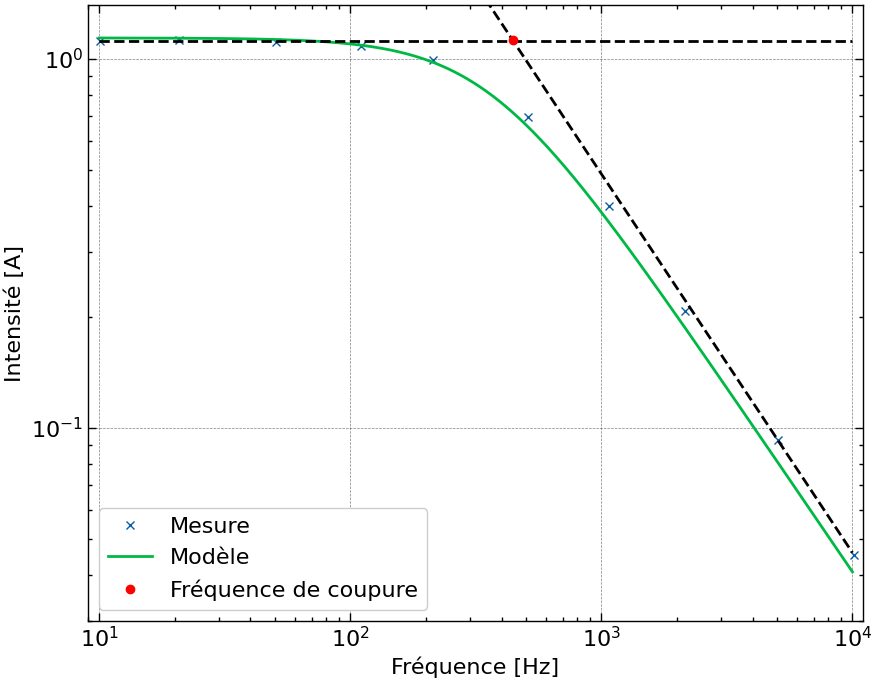

In [32]:
inductance_th = np.mean(inductance[1:]) # H

plt.figure(figsize=(10,8))

plt.plot(freq, tension/res,'x',label='Mesure')

intensite_th = lambda f, U: U/np.sqrt(res**2+(2*np.pi*f * inductance_th)**2)

popt, _ = sc.optimize.curve_fit(intensite_th, freq, tension/res)

print("U_in = {:.3f} V".format(popt[0]))
plt.plot(np.linspace(10,10000,10000), intensite_th(np.linspace(10,10000,10000), *popt), label='Modèle')

# asymptote horizontale
plt.hlines(tension[0]/res, 10, 10000, colors='k', linestyles='dashed')

# asymptote oblique
m = (np.log10(tension[-2]/res) - np.log10(tension[-1]/res)) / (np.log10(freq[-2])- np.log10(freq[-1]))
h = np.log10(tension[-1]/res) - m * np.log10(freq[-1])
line_x = 10**np.linspace(0, 4, 1000)
line_y = 10**(m*np.linspace(0, 4, 1000) + h)
plt.plot(line_x, line_y, 'k--')

# intersection
for i in range(len(line_x)-1):
    if line_y[i] < tension[0]/res < line_y[i+1] or line_y[i] > tension[0]/res > line_y[i+1]:
        intersection = [line_x[i], line_y[i]]

print("f_c = {:.3f} Hz".format(intersection[0]))
plt.plot(intersection[0], intersection[1], 'ro', label='Fréquence de coupure')

plt.xlabel('Fréquence [Hz]')
plt.ylabel('Intensité [A]')
plt.legend(loc='lower left')

plt.xscale('log')
plt.yscale('log')

plt.xlim(9,11000)
plt.ylim(0.03,1.4)

plt.show()

Pour le déphasage, on graphe ce qui a été calculé par la mesure et ce qui va être calculé par la modélitation $\tan(\theta) = \frac{2\pi \cdot f \cdot L}{R}$.

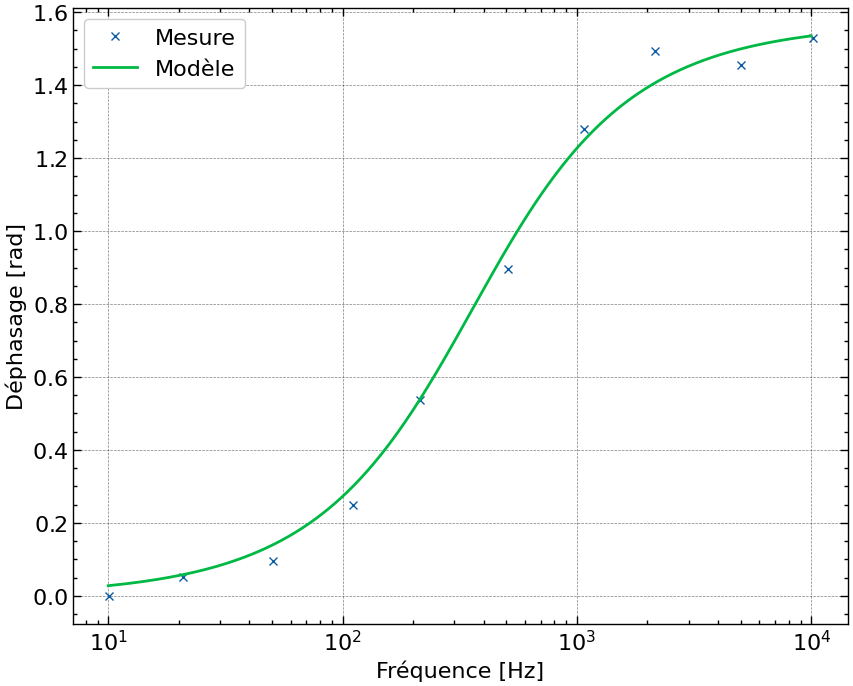

In [33]:
plt.figure(figsize=(10,8))

plt.plot(freq, phase,'x',label='Mesure')

phase_th = lambda f: np.arctan(2*np.pi*f*inductance_th/res)

plt.plot(np.linspace(10,10000,10000), phase_th(np.linspace(10,10000,10000)), label='Modèle')

plt.xlabel('Fréquence [Hz]')
plt.ylabel('Déphasage [rad]')
plt.legend(loc='upper left')

plt.xscale('log')

plt.show()

### De même avec R = 50 [$\Omega$]

In [34]:
res = 50 # Ohm
freq = np.array([10.32,21.03,49.58,119,217.8,505.3,1187,2170,5045,10680]) # Hz
tension = np.array([8.32,8.32,8.32,8.32,8.16,8,7.68,6.52,4,2.06]) # V
diff_t = np.array([0,0.4,0.1,0.08,0.08,0.05,0.056,0.048,0.035,0.02])/1e3 # s

phase = diff_t*2*np.pi*freq # rad
inductance = res/(2*np.pi*freq) * np.tan(phase) # H

display(pd.DataFrame({'freq [Hz]':freq,'tension [V]':tension,'del_t [ms]':diff_t*1e3,'phase':np.round(phase, 3),'inductance [mH]':np.round(inductance*1e3, 3)}))

print('L = {:.3f} mH'.format(np.mean(inductance[2:])*1e3))
print('Écart-type = {:.3f} mH'.format(np.std(inductance[2:])*1e3))

,freq [Hz],tension [V],del_t [ms],phase,inductance [mH]
0,10.32,8.32,0.000,0.000,0.000
1,21.03,8.32,0.400,0.053,20.019
2,49.58,8.32,0.100,0.031,5.002
3,119.00,8.32,0.080,0.060,4.005
4,217.80,8.16,0.080,0.109,4.016
5,505.30,8.00,0.050,0.159,2.521
6,1187.00,7.68,0.056,0.418,2.975
7,2170.00,6.52,0.048,0.654,2.814
8,5045.00,4.00,0.035,1.109,3.173
9,10680.00,2.06,0.020,1.342,3.201


L = 3.463 mH
Écart-type = 0.764 mH


On peut noter que ce coup-ci l'inductance est un peut trop élevée, mais que sur les deux volée de mesure on a une moyenne autour de celle du fabricant.

#### Graphes

U_in = 8.310 V
f_c = 2204.669 Hz


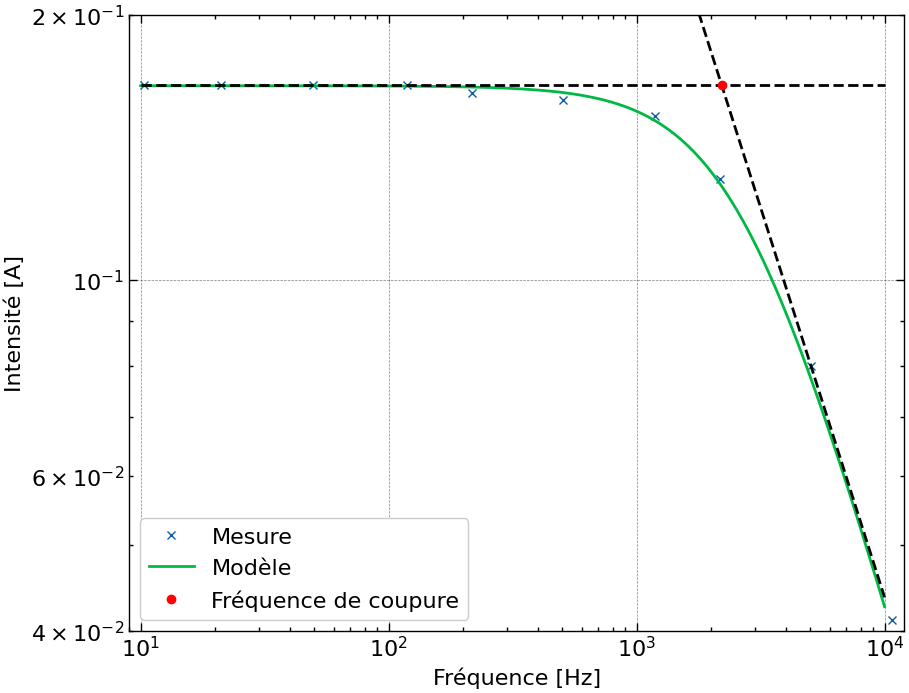

In [35]:
inductance_th = 3e-3 # H

plt.figure(figsize=(10,8))

plt.plot(freq, tension/res,'x',label='Mesure')

intensite_th = lambda f, U: U/np.sqrt(res**2+(2*np.pi*f * inductance_th)**2)

popt, _ = sc.optimize.curve_fit(intensite_th, freq, tension/res)

print("U_in = {:.3f} V".format(popt[0]))
plt.plot(np.linspace(10,10000,10000), intensite_th(np.linspace(10,10000,10000), *popt), label='Modèle')

# asymptote horizontale
plt.hlines(tension[0]/res, 10, 10000, colors='k', linestyles='dashed')

# asymptote oblique
m = (np.log10(tension[-2]/res) - np.log10(tension[-1]/res)) / (np.log10(freq[-2])- np.log10(freq[-1]))
h = np.log10(tension[-1]/res) - m * np.log10(freq[-1])
line_x = 10**np.linspace(0, 4, 1000)
line_y = 10**(m*np.linspace(0, 4, 1000) + h)
plt.plot(line_x, line_y, 'k--')

# intersection
for i in range(len(line_x)-1):
    if line_y[i] < tension[0]/res < line_y[i+1] or line_y[i] > tension[0]/res > line_y[i+1]:
        intersection = [line_x[i], line_y[i]]

print("f_c = {:.3f} Hz".format(intersection[0]))
plt.plot(intersection[0], intersection[1], 'ro', label='Fréquence de coupure')

plt.xlabel('Fréquence [Hz]')
plt.ylabel('Intensité [A]')
plt.legend(loc='lower left')

plt.xscale('log')
plt.yscale('log')

plt.xlim(9,12000)
plt.ylim(0.04,0.2)

plt.show()

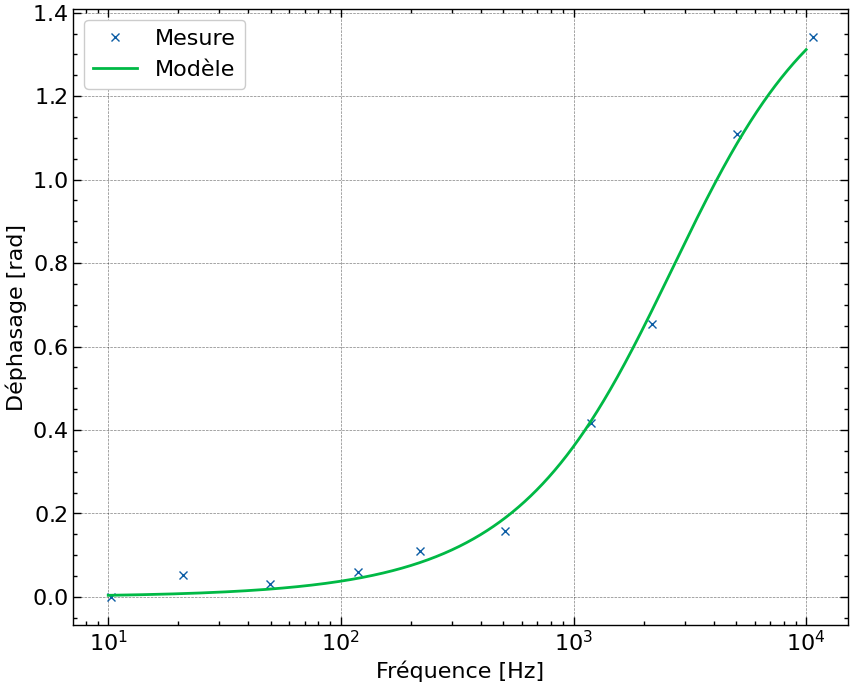

In [36]:
plt.figure(figsize=(10,8))

plt.plot(freq, phase,'x',label='Mesure')

phase_th = lambda f: np.arctan(2*np.pi*f*inductance_th/res)

plt.plot(np.linspace(10,10000,10000), phase_th(np.linspace(10,10000,10000)), label='Modèle')

plt.xlabel('Fréquence [Hz]')
plt.ylabel('Déphasage [rad]')
plt.legend(loc='upper left')

plt.xscale('log')

plt.show()

## Circuit RC et filtre "passe-haut"

Pour celle-ci, nous avons toutes les données pour la tension, mais nous n'avons qu'une série de mesure pour R = 50 [$\Omega$].

La phase est corrigée car elle a été prise selon le plus grand écart dans la mesure.

In [37]:
res = 50 # Ohm
freq = np.array([5.102,10.95,21.1,51.87,104.3,208,516,1034,2185,5060,10980,20460]) # Hz
tension = np.array([0.222,0.28,0.184,0.344,0.62,0.848,1.86,3.3,5.88,8.4,9.2,9.2]) # V
tension_in = np.array([10.2,10.1,10.2,10,9.92,9.92,9.92,9.92,10.1,9.92,9.76,9.36]) # V
diff_t = np.array([100,52.4,29,13.6,6.24,3.28,1.44,0.76,0.38,0.18,0.088,0.0476])/1e3 # s

phase = diff_t*2*np.pi*freq - 2*np.pi # rad
capacite = -1/((2*np.pi*freq*res) * np.tan(phase)) # F

display(pd.DataFrame({'freq [Hz]':freq,'tension [V]':tension,'tension_in [V]':tension_in,'del_t [ms]':diff_t*1e3,'phase':np.round(phase,3), 'capacite [µF]':np.round(capacite*1e6,3)}))

print('C = {:.3f} µF'.format(np.mean(capacite[7:])*1e6))
print('Écart-type = {:.3f} µF'.format(np.std(capacite[7:])*1e6))

,freq [Hz],tension [V],tension_in [V],del_t [ms],phase,capacite [µF]
0,5.102,0.222,10.20,100.0000,-3.078,-9721.527
1,10.950,0.280,10.10,52.4000,-2.678,-581.496
2,21.100,0.184,10.20,29.0000,-2.439,-177.986
3,51.870,0.344,10.00,13.6000,-1.851,-17.648
4,104.300,0.620,9.92,6.2400,-2.194,-21.930
5,208.000,0.848,9.92,3.2800,-1.997,-6.940
6,516.000,1.860,9.92,1.4400,-1.615,-0.270
7,1034.000,3.300,9.92,0.7600,-1.346,0.705
8,2185.000,5.880,10.10,0.3800,-1.066,0.804
9,5060.000,8.400,9.92,0.1800,-0.560,1.002


C = 0.960 µF
Écart-type = 0.219 µF


### Graphes

Pour la tension de mesure, c'est toujours la même formule. Pour celle théorique, on utilise la tension d'entrée et la formule $I = \frac{U}{\sqrt{R^2 + \frac{1}{(2\pi \cdot f \cdot C)^2}}}$.

U_in = 9.725 V
f_c = 2700.421 Hz


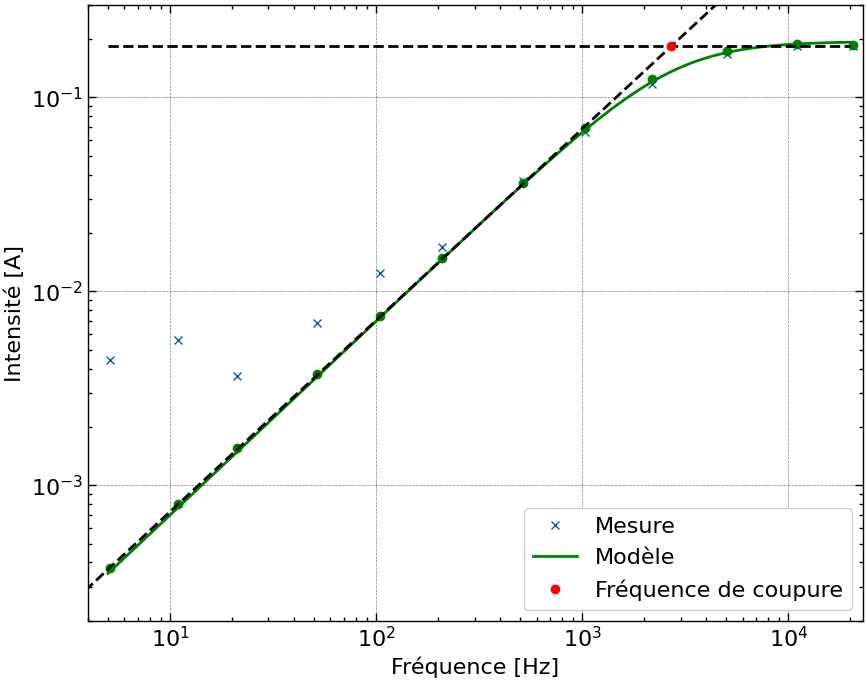

In [38]:
capacite = 1.15e-6 # F

plt.figure(figsize=(10,8))

plt.plot(freq, tension/res,'x',label='Mesure')

intensite_th = lambda f, U: U/np.sqrt(res**2+1/(2*np.pi*f * capacite)**2)

popt, _ = sc.optimize.curve_fit(intensite_th, freq, intensite_th(freq, tension_in))

print("U_in = {:.3f} V".format(popt[0]))
plt.plot(np.linspace(5,20000,10000), intensite_th(np.linspace(5,20000,10000), *popt), 'g-', label='Modèle')
plt.plot(freq, intensite_th(freq, tension_in), 'go')

# asymptote horizontale
plt.hlines(tension[-1]/res, 5, 20000, colors='k', linestyles='dashed')

# asymptote oblique
m = (np.log10(intensite_th(freq, tension_in)[0]) - np.log10(intensite_th(freq, tension_in)[1])) / (np.log10(freq[0])- np.log10(freq[1]))
h = np.log10(intensite_th(freq, tension_in)[1]) - m * np.log10(freq[1])
line_x = 10**np.linspace(0, 4, 1000)
line_y = 10**(m*np.linspace(0, 4, 1000) + h)
plt.plot(line_x, line_y, 'k--')

# intersection
for i in range(len(line_x)-1):
    if line_y[i] < tension[-1]/res < line_y[i+1] or line_y[i] > tension[-1]/res > line_y[i+1]:
        intersection = [line_x[i], line_y[i]]

print("f_c = {:.3f} Hz".format(intersection[0]))
plt.plot(intersection[0], intersection[1], 'ro', label='Fréquence de coupure')

plt.xlabel('Fréquence [Hz]')
plt.ylabel('Intensité [A]')
plt.legend(loc='lower right')

plt.xscale('log')
plt.yscale('log')

plt.xlim(4,23000)
plt.ylim(0.0002,0.3)

plt.show()

Pour le déphasage, on a une équation similaire à précédemment : $\tan \theta = - \frac{1}{2\pi \cdot f \cdot R \cdot C}$.

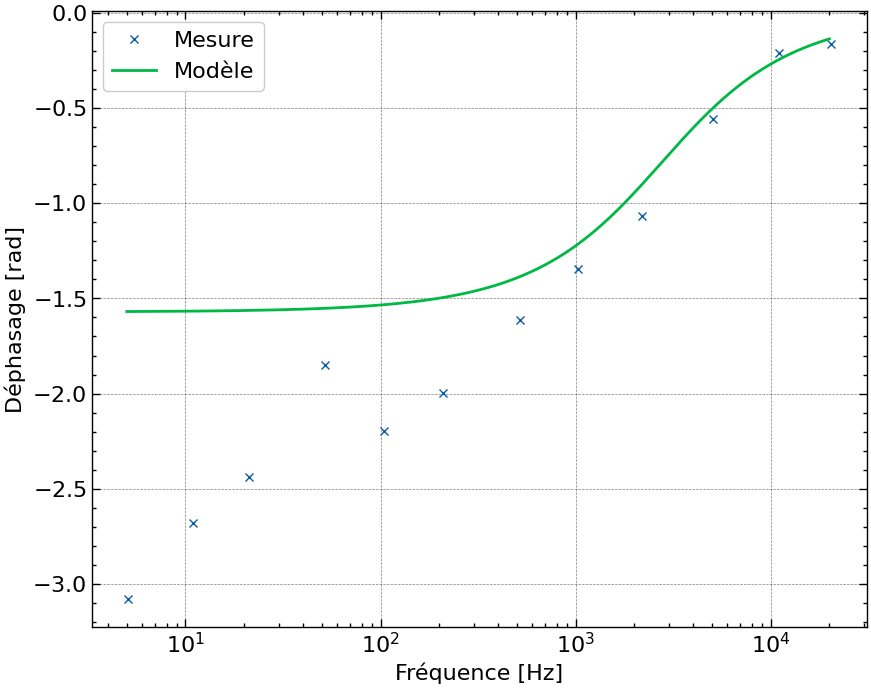

In [39]:
plt.figure(figsize=(10,8))

plt.plot(freq, phase,'x',label='Mesure')

phase_th = lambda f: np.arctan(-1/(2*np.pi*f*res*capacite))

plt.plot(np.linspace(5,20000,10000), phase_th(np.linspace(5,20000,10000)), label='Modèle')

plt.xlabel('Fréquence [Hz]')
plt.ylabel('Déphasage [rad]')
plt.legend(loc='upper left')

plt.xscale('log')

plt.show()